In [28]:
import sys
import re
import json
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pyvis.network import Network
import copy
import os
import csv
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.inspection import permutation_importance
import traceback
from sklearn.feature_extraction import DictVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import time
import psutil 
from IPython.display import clear_output
from memory_profiler import profile

In [29]:
log_directory= '<Testing Log Directory>'

In [30]:
def extract_features(G):
    try:
        features = {}
        
        # Basic graph features
        features['num_nodes'] = G.number_of_nodes()
        features['num_edges'] = G.number_of_edges()
        features['avg_degree'] = sum(dict(G.degree()).values()) / G.number_of_nodes() if G.number_of_nodes() > 0 else 0
        features['density'] = nx.density(G)
        
        # Node type features
        node_types = [data.get('type', 'unknown') for _, data in G.nodes(data=True)]
        for node_type in set(node_types):
            features[f'num_{node_type}_nodes'] = node_types.count(node_type)
        
        # Edge type (syscall) features
        edge_types = [data.get('syscall', 'unknown') for _, _, data in G.edges(data=True)]
        for edge_type in set(edge_types):
            features[f'num_{edge_type}_syscalls'] = edge_types.count(edge_type)
        
        # Centrality measures
        if G.number_of_nodes() > 0:
            degree_centrality = nx.degree_centrality(G)
            features['max_degree_centrality'] = max(degree_centrality.values())
            features['avg_degree_centrality'] = sum(degree_centrality.values()) / len(degree_centrality)
            
            betweenness_centrality = nx.betweenness_centrality(G)
            features['max_betweenness_centrality'] = max(betweenness_centrality.values())
            features['avg_betweenness_centrality'] = sum(betweenness_centrality.values()) / len(betweenness_centrality)
            
            closeness_centrality = nx.closeness_centrality(G)
            features['max_closeness_centrality'] = max(closeness_centrality.values())
            features['avg_closeness_centrality'] = sum(closeness_centrality.values()) / len(closeness_centrality)
        
        # Connected components
        undirected_G = G.to_undirected()
        features['num_connected_components'] = nx.number_connected_components(undirected_G)
        
        # Largest connected component features
        largest_cc = max(nx.connected_components(undirected_G), key=len)
        largest_cc_subgraph = G.subgraph(largest_cc)
        features['largest_cc_num_nodes'] = largest_cc_subgraph.number_of_nodes()
        features['largest_cc_num_edges'] = largest_cc_subgraph.number_of_edges()
    
        
        # Assortativity
        features['degree_assortativity'] = nx.degree_assortativity_coefficient(G)
        
        # Node connectivity
        features['node_connectivity'] = nx.node_connectivity(G)
        
        # Edge connectivity
        features['edge_connectivity'] = nx.edge_connectivity(G)
        
        # Degree distribution statistics
        degrees = [d for _, d in G.degree()]
        features['degree_std'] = np.std(degrees)
        features['degree_skewness'] = pd.Series(degrees).skew()
        features['degree_kurtosis'] = pd.Series(degrees).kurtosis()
        
        return features
    except Exception as e:
        print(f"Error in extract_features: {str(e)}")
        traceback.print_exc()
        return {}


In [31]:
def process_log_file(file_path):
    G = nx.MultiDiGraph()
    processes = {}
    files = {}
    sockets = {}

    with open(file_path, 'r') as file:
        for line in file:
            try:
                event = json.loads(line)
                
                # Process node
                process_id = f"process_{event['processId']}_{event['threadId']}"
                if process_id not in G:
                    G.add_node(process_id, type='process', name=event['processName'], 
                               pid=event['processId'], tid=event['threadId'])
                
                # Event handling
                syscall = event['syscall']
                timestamp = event['timestamp']
                
                if syscall in ['open', 'openat', 'read', 'write', 'close', 'unlink']:
                    for arg in event['args']:
                        if arg['name'] in ['pathname', 'filename']:
                            file_path = arg['value']
                            file_id = f"file_{file_path}"
                            if file_id not in G:
                                G.add_node(file_id, type='file', name=file_path)
                            G.add_edge(process_id, file_id, syscall=syscall, timestamp=timestamp)
                
                elif syscall in ['connect', 'bind', 'accept']:
                    for arg in event['args']:
                        if arg['name'] == 'addr':
                            addr = arg['value']
                            socket_id = f"socket_{addr['sin_addr']}:{addr['sin_port']}"
                            if socket_id not in G:
                                G.add_node(socket_id, type='socket', 
                                           ip=addr['sin_addr'], port=addr['sin_port'])
                            G.add_edge(process_id, socket_id, syscall=syscall, timestamp=timestamp)
                
                elif syscall in ['clone', 'fork', 'vfork']:
                    child_id = f"process_{event['returnValue']}_{event['returnValue']}"
                    G.add_node(child_id, type='process', name=event['processName'], 
                               pid=event['returnValue'], tid=event['returnValue'])
                    G.add_edge(process_id, child_id, syscall=syscall, timestamp=timestamp)
                
                elif syscall == 'execve':
                    for arg in event['args']:
                        if arg['name'] == 'filename':
                            binary_path = arg['value']
                            binary_id = f"binary_{binary_path}"
                            if binary_id not in G:
                                G.add_node(binary_id, type='binary', name=binary_path)
                            G.add_edge(process_id, binary_id, syscall=syscall, timestamp=timestamp)
                
            except json.JSONDecodeError:
                print(f"Error decoding JSON from line: {line}")
            except KeyError as e:
                print(f"KeyError: {e} in line: {line}")
    return G


In [32]:
def process_log_file2(log_file_path):
    try:
        COMPRESS_THE_GRAPH = True
        HIERARCHICAL = False
        
        edges = []
        nodes = {}
        node_file_details = {}
        node_reverse_map = {}
        file_reverse_map = {} # (host_pid, host_tid, fd) -> node id
        deleted_files_map = {} # (dirfd, path) -> node id
        
        connections_map = {} # (server_IP, server_Port) -> (client IP, client port) 
        ip_port_id_map = {} #(ip,port) -> node id
        
        clone_map = {} # (host pid, retval tid, type (p:0 or c:1)) -> node id
        
        existing_binaries = {} # (name) -> node id

        waiting_for_accept = {} # (server_IP, server_Port) -> [node_id, ...]
        
        node_counter = 1 
        
        nodes[node_counter] = {
            "type" : "exit"
        }
        node_counter = node_counter + 1 
        nodes[node_counter] = {
            "type" : "error"
        }
        node_counter = node_counter + 1 
        
        # Read each line from the log file
        with open(log_file_path, 'r') as file:
            for line in file:
                try:
                    json_data = json.loads(line.strip())
                    
                    host_pid = json_data["hostProcessId"]
                    host_tid = json_data["hostThreadId"]
                    timestamp = json_data["timestamp"]
                    syscall_name = json_data["syscall"]
                    
                    if (host_pid, host_tid) not in node_reverse_map:
                        node_reverse_map[(host_pid, host_tid)] = node_counter
                        nodes[node_counter] = {
                            "type": "process",
                            "host_pid": host_pid, 
                            "host_tid": host_tid, 
                            "task_command": json_data["processName"]
                        }
                        node_file_details[node_counter] = {}
                        node_counter = node_counter + 1
                    
                    current_node_id = node_reverse_map[(host_pid, host_tid)]
                    
                    if (syscall_name != "exit") and (int(json_data["returnValue"]) < 0):
                        edges.append((current_node_id, 2, {"syscall": f"{syscall_name}", "timestamp": timestamp}))
                        continue
                    
                    if syscall_name == "openat":
                        retval = json_data["returnValue"]
                        filename = next(arg["value"] for arg in json_data["args"] if arg["name"] == "pathname")
                        if (host_pid, host_tid, retval) not in file_reverse_map:
                            file_reverse_map[(host_pid, host_tid, retval)] = node_counter
                            nodes[node_counter] = {
                                "type": "file",
                                "file_name": filename
                            }
                            node_counter = node_counter + 1
                        file_node_id = file_reverse_map[(host_pid, host_tid, retval)]
                        node_file_details[current_node_id][retval] = file_node_id
                        edges.append((current_node_id, file_node_id, {"syscall": "open", "timestamp": timestamp}))
                    
                    elif syscall_name == "read":
                        file_desc = next(arg["value"] for arg in json_data["args"] if arg["name"] == "fd")
                        if file_desc not in node_file_details[current_node_id]:
                            # Create file node 
                            file_reverse_map[(host_pid, host_tid, file_desc)] = node_counter
                            nodes[node_counter] = {
                                "type": "file",
                                "file_name": "unknown"
                            }
                            node_counter = node_counter + 1
                            # Assign to current process
                            file_node_id = file_reverse_map[(host_pid, host_tid, file_desc)]
                            node_file_details[current_node_id][file_desc] = file_node_id
                            
                        edges.append((current_node_id, node_file_details[current_node_id][file_desc], {"syscall": f"{syscall_name}", "timestamp": timestamp}))
                    
                    elif syscall_name == "close":
                        file_desc = next(arg["value"] for arg in json_data["args"] if arg["name"] == "fd")
                        if file_desc in node_file_details[current_node_id]:
                            edges.append((current_node_id, node_file_details[current_node_id][file_desc], {"syscall": f"{syscall_name}", "timestamp": timestamp}))
                            if (host_pid, host_tid, file_desc) in file_reverse_map:
                                file_reverse_map.pop((host_pid, host_tid, file_desc))
                            node_file_details[current_node_id].pop(file_desc)
                    
                    # Add more syscall handling here as needed
                    
                except json.JSONDecodeError as e:
                    print(f"Error parsing JSON: {e}")
                    continue
                except Exception as e:
                    print(f"Error processing line: {e}")
                    continue

        # Create a networkx graph
        G = nx.MultiDiGraph()
        G.add_nodes_from(nodes.keys())
        G.add_edges_from(edges)

        # Compression logic (if needed)
        if COMPRESS_THE_GRAPH:
            # Implement compression logic here
            pass

        # Create a Pyvis network
        net = Network(height="500px", width="100%", notebook=True, directed=True, cdn_resources='in_line', select_menu=True, filter_menu=True)

        # Add nodes to the network
        for node_id, props in nodes.items():
            if props['type'] == 'process':
                net.add_node(node_id, label=f"{props['type']} node\nHost pid: {props.get('host_pid', '')}\nHost tid: {props.get('host_tid', '')}\nTask Command: {props.get('task_command', '')}", color='orange')
            elif props['type'] == 'file':
                net.add_node(node_id, label=f"{props['type']} node\nfilename: {props.get('file_name', '')}", color='blue')
            else:
                net.add_node(node_id, label=f"{props['type']} node", color='gray')

        # Add edges to the network
        for u, v, dicti in edges:
            net.add_edge(u, v, label=f"{dicti['syscall']}, {dicti['timestamp']}")

        # Set layout and show buttons
        net.set_edge_smooth('dynamic')
        net.show_buttons(filter_=['physics'])

        # Save the graph
        html_file_path = f"graph_{log_file_path.split('/')[-1].split('.')[0]}_{'compressed' if COMPRESS_THE_GRAPH else 'uncompressed'}.html"
        net.show(html_file_path)

        print(f"Graph saved to {html_file_path}")

        #return G  # Return the networkx graph for further analysis if needed
        features = extract_features(G)
        return features
    except Exception as e:
        print(f"Error in process_log_file for {log_file_path}: {str(e)}")
        traceback.print_exc()
        return None

In [33]:
def process_directory(directory_path):
    all_features = []
    error_files = []  # New list to keep track of files with errors
    labels = []
    for root, dirs, files in os.walk(directory_path):
        for filename in files:
            if filename.endswith(".log"):
                file_path = os.path.join(root, filename)
                print(f"Processing file: {file_path}")  # Debug print
                try:
                    features = process_log_file2(file_path)
                    if features is not None:
                        labels.append(filename)
                    all_features.append(features)
                    print(f"Extracted features: {features}")  # Debug print
                except Exception as e:
                    print(f"Error processing {file_path}: {str(e)}")  # Debug print
                    error_files.append((file_path, str(e)))  # Add to error list
    print(f"Total features extracted: {len(all_features)}")  # Debug print
    if error_files:
        print("\nFiles with errors:")
        for file_path, error in error_files:
            print(f"- {file_path}: {error}")
    return all_features,labels

In [ ]:
ans = process_directory(log_directory)
print(ans)
all_features = ans[0]
labels = ans[1]
print(len(labels))
print(all_features)

In [ ]:
all_features
all_features = ans[0]
labels = ans[1]
print(len(labels))
print(all_features)
print(labels)

In [9]:
all_features
all_features = [item for item in all_features if item is not None]

In [ ]:
labels
num_of_classes = []
for label in labels:
    if 'downloadphoto' in label and 'normal' in label:
        num_of_classes.append(1)
    elif 'getprofile' in label and 'normal' in label:
        num_of_classes.append(2)
    elif 'getrecommendation' in label and 'normal' in label:
        num_of_classes.append(3)
    elif 'loginuser' in label and 'normal' in label:
        num_of_classes.append(4)
    elif 'registeruser' in label and 'normal' in label:
        num_of_classes.append(5)
    elif 'updaterecommendation' in label and 'normal' in label:
        num_of_classes.append(6)
    #elif 'uploadphoto' in label and 'normal' in label:
    #    num_of_classes.append(7)
    elif 'viewphoto' in label and 'normal' in label:
        num_of_classes.append(7)
    elif 'arithmaticevalprofile' in label and 'attack' in label:
        num_of_classes.append(8)
    elif 'photosrce' in label and 'attack' in label:
        num_of_classes.append(9)
    elif 'sqlinjectionphotos' in label and 'attack' in label:
        num_of_classes.append(10)
    elif 'sqlinjectionusers' in label and 'attack' in label:
        num_of_classes.append(11)
    elif 'uploadphp' in label and 'attack' in label:
        num_of_classes.append(12)

print(len(labels))
print(num_of_classes)
print(len(num_of_classes))

freq_of_classes = {item: num_of_classes.count(item) for item in num_of_classes}
print(freq_of_classes)

In [ ]:
df = pd.DataFrame(all_features)
print(df.shape)
df = df.fillna(0)
print(df.shape)
print(len(labels))

df.head()

In [7]:
class ResourceMonitor:
    def __init__(self):
        self.process = psutil.Process(os.getpid())
        self.cpu_percents = []
        self.memory_usages = []
        self.timestamps = []
        self.start_time = time.time()

    def record_usage(self):
        # Measure CPU usage over 0.1 second interval
        cpu_percent = psutil.cpu_percent(interval=0.1)
        memory_info = self.process.memory_info()
        memory_usage = memory_info.rss / 1024 / 1024  # Convert to MB
        
        self.cpu_percents.append(cpu_percent)
        self.memory_usages.append(memory_usage)
        self.timestamps.append(time.time() - self.start_time)

    def plot_results(self):
        plt.figure(figsize=(12, 6))
        
        plt.subplot(2, 1, 1)
        plt.plot(self.timestamps, self.cpu_percents)
        plt.xlabel('Time (seconds)')
        plt.ylabel('CPU Usage (%)')
        plt.title('CPU Usage Over Time')
        
        plt.subplot(2, 1, 2)
        plt.plot(self.timestamps, self.memory_usages)
        plt.xlabel('Time (seconds)')
        plt.ylabel('Memory Usage (MB)')
        plt.title('Memory Usage Over Time')
        
        plt.tight_layout()
        plt.show()

    def print_summary(self):
        print(f"Total runtime: {self.timestamps[-1]:.2f} seconds")
        print(f"Average CPU usage: {sum(self.cpu_percents) / len(self.cpu_percents):.2f}%")
        print(f"Peak CPU usage: {max(self.cpu_percents):.2f}%")
        print(f"Average memory usage: {sum(self.memory_usages) / len(self.memory_usages):.2f} MB")
        print(f"Peak memory usage: {max(self.memory_usages):.2f} MB")


In [ ]:
try:
    #monitor = ResourceMonitor()
    #start_time = time.time()
    #while time.time() - start_time < 60:  # Run for 60 seconds or adjust as needed
    #    monitor.record_usage() 
    ans = process_directory(log_directory)
    all_features = ans[0]
    labels = ans[1]
    if not all_features:
        print("No features were extracted. Check your log files and processing logic.")
    else:
        # Save features to CSV
        all_features = [item for item in all_features if item is not None]
        df = pd.DataFrame(all_features)
        df = df.fillna(0)
        
        num_of_classes = []
        for label in labels:
            if 'downloadphoto' in label and 'normal' in label:
                num_of_classes.append(1)
            elif 'getprofile' in label and 'normal' in label:
                num_of_classes.append(2)
            elif 'getrecommendation' in label and 'normal' in label:
                num_of_classes.append(3)
            elif 'loginuser' in label and 'normal' in label:
                num_of_classes.append(4)
            elif 'registeruser' in label and 'normal' in label:
                num_of_classes.append(5)
            elif 'updaterecommendation' in label and 'normal' in label:
                num_of_classes.append(6)
            #elif 'uploadphoto' in label and 'normal' in label:
            #    num_of_classes.append(7)
            elif 'viewphoto' in label and 'normal' in label:
                num_of_classes.append(7)
            elif 'arithmaticevalprofile' in label and 'attack' in label:
                num_of_classes.append(8)
            elif 'photosrce' in label and 'attack' in label:
                num_of_classes.append(9)
            elif 'sqlinjectionphotos' in label and 'attack' in label:
                num_of_classes.append(10)
            elif 'sqlinjectionusers' in label and 'attack' in label:
                num_of_classes.append(11)
            elif 'uploadphp' in label and 'attack' in label:
                num_of_classes.append(12)

        
        
        csv_path = "provenance_features_KNN_Tracee.csv"
        df.to_csv(csv_path, index=False)
        print(f"Features saved to {csv_path}")
        
except Exception as e:
    print(f"Error in analysis: {str(e)}")
    traceback.print_exc()
    

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
print(len(labels))
num_of_classes = []
for label in labels:
    if 'downloadphoto' in label and 'normal' in label:
        num_of_classes.append(1)
    elif 'getprofile' in label and 'normal' in label:
        num_of_classes.append(2)
    elif 'getrecommendation' in label and 'normal' in label:
        num_of_classes.append(3)
    elif 'loginuser' in label and 'normal' in label:
        num_of_classes.append(4)
    elif 'registeruser' in label and 'normal' in label:
        num_of_classes.append(5)
    elif 'updaterecommendation' in label and 'normal' in label:
        num_of_classes.append(6)
    elif 'uploadphoto' in label and 'normal' in label:
       num_of_classes.append(7)
    elif 'viewphoto' in label and 'normal' in label:
        num_of_classes.append(7)
    elif 'arithmaticevalprofile' in label and 'attack' in label:
        num_of_classes.append(8)
    elif 'photorce' in label and 'attack' in label:
        num_of_classes.append(9)
    elif 'sqlinjectionphotos' in label and 'attack' in label:
        num_of_classes.append(10)
    elif 'sqlinjectionusers' in label and 'attack' in label:
        num_of_classes.append(11)
    elif 'uploadphp' in label and 'attack' in label:
        num_of_classes.append(12)
    else:
        print(label)
        

print(len(labels))
print(num_of_classes)
print(len(num_of_classes))

freq_of_classes = {item: num_of_classes.count(item) for item in num_of_classes}
print(freq_of_classes)

In [21]:
X = df
Y = num_of_classes
print(len(df))
print(len(num_of_classes))

1873
1873


Test accuracy: 0.4827
Train Accuracy: 0.6447
Test Accuracy: 0.4827
Train Loss (Error Rate): 0.3553
Test Loss (Error Rate): 0.5173
Precision: 0.4776
Recall: 0.4666
F1 Score: 0.4618
Confusion Matrix:
[[57  2  1  0  3  0  1  0  0  1  0  0]
 [ 2 22  1  3 12  4  0  7  0  2  0  3]
 [ 1  2 30  3  2 14  3  1  2  0  0  0]
 [ 2 11  2 12 16  1  2  1  2  1  4  0]
 [ 3  8  1 14 37  3  0  3  1  0  6  0]
 [ 0  2  8  4  5 33  2  1  0  0  0  0]
 [ 1  0  7  1  2  3 37  1  1  7  2  3]
 [ 9  9  1  7 16  0  0  7  1  0  1  1]
 [ 0  5  4  7  2  4  1  3 48  0  1  1]
 [ 0  4  5  1  0  1 11  2  7 32  0  2]
 [ 2 18  1 11  6  3  1  3  0  2  7  1]
 [ 4  2  1  2  2  2 10  1  1  5  3 40]]


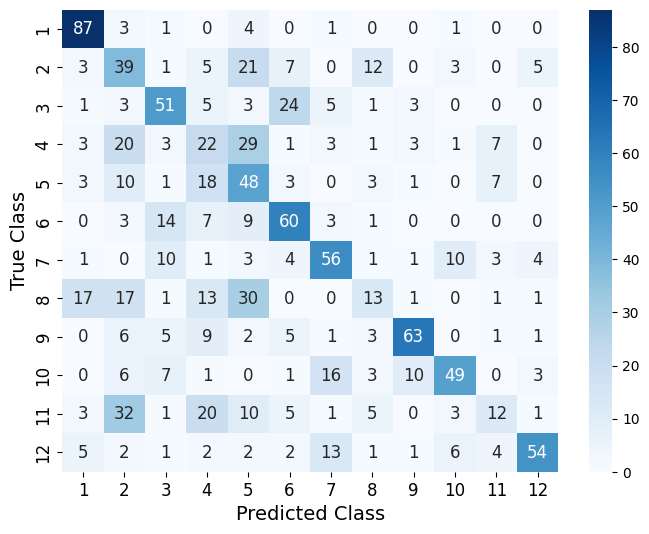

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X and Y are pandas DataFrames/Series
# X: features, Y: target labels

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=67, stratify=Y)

# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")

# Predict on the test set
y_pred_test = knn.predict(X_test)

# Predict on the training set (for loss calculation)
y_pred_train = knn.predict(X_train)

# Calculate test and training accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Calculate training and test loss (error rate)
train_loss = 1 - train_accuracy
test_loss = 1 - test_accuracy

# If the training accuracy is significantly higher than the test accuracy, or the training loss is much lower than the test loss, overfitting might be happening. A small gap between training and test metrics indicates that the model is generalizing well.
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Loss (Error Rate): {train_loss:.4f}")
print(f"Test Loss (Error Rate): {test_loss:.4f}")

# Calculate precision, recall, and F1 score for the test set
precision = precision_score(y_test, y_pred_test, average='macro')
recall = recall_score(y_test, y_pred_test, average='macro')
f1 = f1_score(y_test, y_pred_test, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# roc_auc = roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])
# print(f"ROC AUC: {roc_auc:.4f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print class-wise confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100
conf_matrix_percentage = conf_matrix_percentage.astype(int)


# Optional: Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8,6))
#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], yticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], annot_kws={"size": 12})
sns.heatmap(conf_matrix_percentage, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], yticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], annot_kws={"size": 12})

plt.xlabel("Predicted Class", fontsize = 14)
plt.ylabel("True Class", fontsize = 14)
#plt.title("Confusion Matrix")
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)
plt.show()

Train Accuracy: 0.1255
Test Accuracy: 0.0987
Precision: 0.1153
Recall: 0.0987
F1 Score: 0.0902
Train Loss (Inertia): 8329243.3387
Confusion Matrix:
[[ 0 16  0  0  0  7  1  0  0  1  2  0]
 [ 0  1  2  4  5  1  6  0  0  0  9  3]
 [ 4  0  1  0  0  2 11  0  0  0  9  2]
 [ 1  0  0  9  1  0  4  0  4  1  9  0]
 [ 2  0  1  1  1  2  9  0  1  6 17  0]
 [ 2  0  3  1  1  3  3  2  0  0  7  0]
 [ 1 13  3  1  0  3  1  0  1  0  1  1]
 [ 3  0  2  0  0  1  8  1  1  1  7  2]
 [ 4  1  2  0  2  2  2  0  0  0 25  1]
 [ 3 15  2  0  3  4  1  0  2  0  1  2]
 [ 0  0  0 12  6  0  4  0  3  1  9  0]
 [ 0 21  5  1  2  2  2  0  1  2  3  0]]


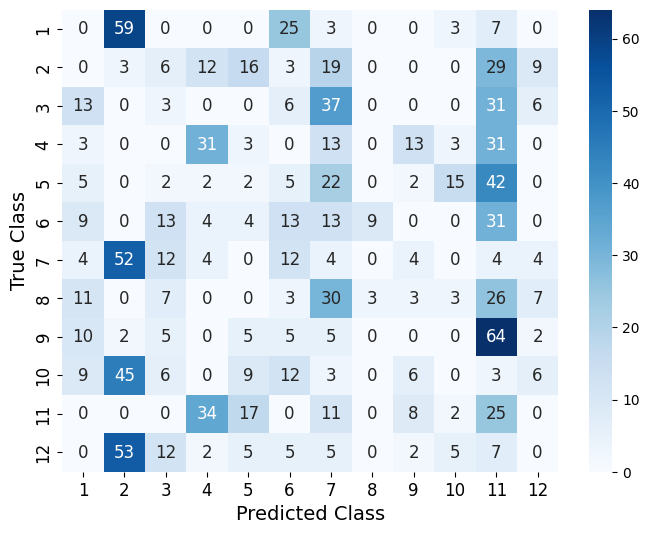

In [24]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

# Generate synthetic data
# n_samples = 3000
# n_features = 2
n_clusters = 12
# X, y_true = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42)
X = df
y_true = [x - 1 for x in num_of_classes] 
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.2, random_state=30)

# Standardize the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Apply K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=12, n_init=10)
kmeans.fit(X_train)

# Predict clusters for training and testing data
y_train_pred = kmeans.predict(X_train)
y_test_pred = kmeans.predict(X_test)

# Calculate inertia (within-cluster sum of squares) for train and test sets
train_loss = kmeans.inertia_
cluster_labels = kmeans.labels_

# test_loss = np.sum(np.min(np.sum((X_test[:, np.newaxis] - kmeans.cluster_centers_) ** 2, axis=2), axis=1))

# Function to align cluster labels with true labels
def align_labels(y_true, y_pred):
    from scipy.optimize import linear_sum_assignment
    confusion_matrix = np.zeros((n_clusters, n_clusters))
    for i in range(len(y_true)):
        confusion_matrix[y_true[i], y_pred[i]] += 1
    row_ind, col_ind = linear_sum_assignment(-confusion_matrix)
    return np.array([col_ind[i] for i in y_pred])

# Align predicted labels with true labels
y_train_pred_aligned = align_labels(y_train, y_train_pred)
y_test_pred_aligned = align_labels(y_test, y_test_pred)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred_aligned)
test_accuracy = accuracy_score(y_test, y_test_pred_aligned)
precision = precision_score(y_test, y_test_pred_aligned, average='weighted')
recall = recall_score(y_test, y_test_pred_aligned, average='weighted')
f1 = f1_score(y_test, y_test_pred_aligned, average='weighted')

# Print results
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Train Loss (Inertia): {train_loss:.4f}")
# print(f"Test Loss (Inertia): {test_loss:.4f}")

# Calculate and print confusion matrix to compare clustering result with true labels
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)
conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100
conf_matrix_percentage = conf_matrix_percentage.astype(int)


# Optional: Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8,6))
#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], yticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], annot_kws={"size": 12})
sns.heatmap(conf_matrix_percentage, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], yticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], annot_kws={"size": 12})

plt.xlabel("Predicted Class", fontsize = 14)
plt.ylabel("True Class", fontsize = 14)
#plt.title("Confusion Matrix")
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)
plt.show()




Test accuracy: 0.3869
Train Accuracy: 0.5695
Test Accuracy: 0.5804
Train Loss (Error Rate): 0.4305
Test Loss (Error Rate): 0.4196
Confusion Matrix:
[[100   6   3   5   7   0   0   3   0   1   1   4]
 [  1  50   3   1  37   4   1   7   3   0   4   1]
 [  3  15  44   8   3  19   4   1  13   3   2   1]
 [  2  27   5  18  32   2   2   2   0   5  10   3]
 [  1  38   4   4  91   3   0   5   4   0   2   0]
 [  2  13  47   4   5  14   2   5  10   3   2   3]
 [  5   0  13   1   7   7  41   1   8   5   1  41]
 [  1  28   4   4  41   2   0  13   7   3   0   1]
 [  2  10  10   2  13   4   1   5 100   2   3   0]
 [  4   2   3   2   3   2  16   1   5  39   5  47]
 [  2  29   1  12  32   0   1   1   0  10  20   2]
 [  7   7   5   4   4   7  45   0   1  14   2  50]]


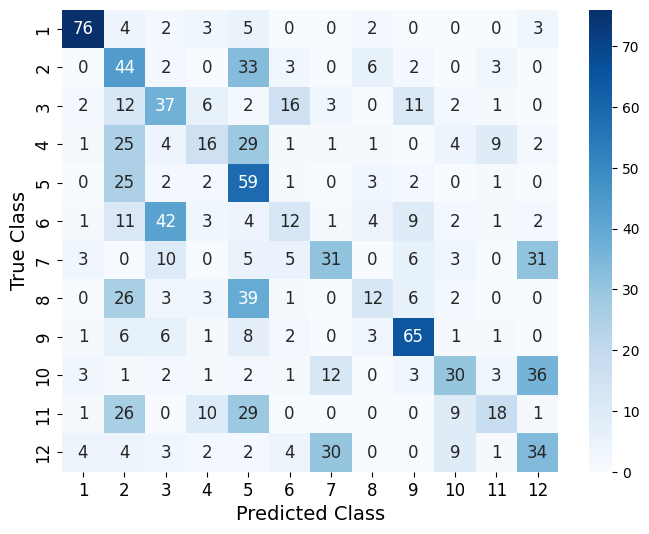


Classification Report:
              precision    recall  f1-score   support

           1       0.77      0.77      0.77       130
           2       0.22      0.45      0.30       112
           3       0.31      0.38      0.34       116
           4       0.28      0.17      0.21       108
           5       0.33      0.60      0.43       152
           6       0.22      0.13      0.16       110
           7       0.36      0.32      0.34       130
           8       0.30      0.12      0.18       104
           9       0.66      0.66      0.66       152
          10       0.46      0.30      0.36       129
          11       0.38      0.18      0.25       110
          12       0.33      0.34      0.33       146

    accuracy                           0.39      1499
   macro avg       0.38      0.37      0.36      1499
weighted avg       0.40      0.39      0.38      1499



In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X and Y are pandas DataFrames/Series
# X: features, Y: target labels

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.8, random_state=32, stratify=Y)

# Initialize the SVM classifier with a specified kernel (e.g., 'linear', 'rbf', etc.)
svm = SVC(kernel='linear', random_state=4)  # You can change the kernel type as needed

# Train the model
svm.fit(X_train, y_train)

# Predict on the test set
y_pred = svm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")

# Predict on the test set
y_pred_test = knn.predict(X_test)

# Predict on the training set (for loss calculation)
y_pred_train = knn.predict(X_train)

# Calculate test and training accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Calculate training and test loss (error rate)
train_loss = 1 - train_accuracy
test_loss = 1 - test_accuracy

# If the training accuracy is significantly higher than the test accuracy, or the training loss is much lower than the test loss, overfitting might be happening. A small gap between training and test metrics indicates that the model is generalizing well.
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Loss (Error Rate): {train_loss:.4f}")
print(f"Test Loss (Error Rate): {test_loss:.4f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print class-wise confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100
conf_matrix_percentage = conf_matrix_percentage.astype(int)


# Optional: Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8,6))
#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], yticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], annot_kws={"size": 12})
sns.heatmap(conf_matrix_percentage, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], yticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], annot_kws={"size": 12})

plt.xlabel("Predicted Class", fontsize = 14)
plt.ylabel("True Class", fontsize = 14)
#plt.title("Confusion Matrix")
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Train Accuracy: 0.9700
Test Accuracy: 0.5173
Precision: 0.5407
Recall: 0.5173
F1 Score: 0.5215

Confusion Matrix:
[[26  0  1  0  2  0  0  1  0  0  2  0]
 [ 0  8  0  1  8  0  0  7  2  0  2  0]
 [ 0  0 20  2  2  3  2  0  2  1  0  0]
 [ 0  2  1  6  5  1  1  3  0  0  6  0]
 [ 0  2  0  1 13  1  2  2  3  0  4  0]
 [ 1  0  9  1  1 13  2  0  0  1  0  0]
 [ 1  0  2  1  0  0 23  0  3  5  0  3]
 [ 0  2  0  2 10  0  2  8  1  0  3  0]
 [ 0  2  0  2  3  1  1  1 23  1  1  3]
 [ 2  0  4  0  1  1  1  0  2 20  4  0]
 [ 2  1  0  2  4  2  0  0  1  1 10  1]
 [ 0  0  0  0  1  0  2  0  1  6  5 24]]


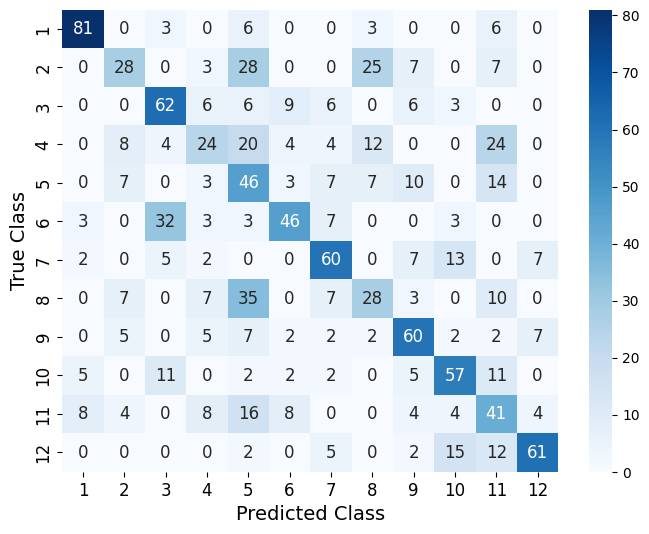


Top 10 Important Features:
Feature 1: 0.0818
Feature 5: 0.0722
Feature 18: 0.0660
Feature 7: 0.0577
Feature 23: 0.0568
Feature 21: 0.0533
Feature 22: 0.0526
Feature 8: 0.0524
Feature 13: 0.0493
Feature 2: 0.0417


In [26]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.datasets import make_classification

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Preprocess the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, Y_train)

# Make predictions
Y_train_pred = rf_model.predict(X_train_scaled)
Y_test_pred = rf_model.predict(X_test_scaled)

# Calculate metrics
train_accuracy = accuracy_score(Y_train, Y_train_pred)
test_accuracy = accuracy_score(Y_test, Y_test_pred)
precision = precision_score(Y_test, Y_test_pred, average='weighted')
recall = recall_score(Y_test, Y_test_pred, average='weighted')
f1 = f1_score(Y_test, Y_test_pred, average='weighted')

# Calculate confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_test_pred)

# Print results
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100
conf_matrix_percentage = conf_matrix_percentage.astype(int)


# Optional: Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8,6))
#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], yticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], annot_kws={"size": 12})
sns.heatmap(conf_matrix_percentage, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], yticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], annot_kws={"size": 12})

plt.xlabel("Predicted Class", fontsize = 14)
plt.ylabel("True Class", fontsize = 14)
#plt.title("Confusion Matrix")
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)
plt.show()
# Feature importance
feature_importance = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
top_10_features = sorted_idx[-10:]

print("\nTop 10 Important Features:")
for idx in reversed(top_10_features):
    print(f"Feature {idx}: {feature_importance[idx]:.4f}")

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

# Generate a sample dataset
# Replace this with your own X and Y data
n_classes = 12  # Number of classes
# X, Y = make_classification(n_samples=1000, n_features=20, n_classes=n_classes, n_informative=15, random_state=42)
Y_2 = [x - 1 for x in num_of_classes] 
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_2, test_size=0.2, random_state=42)

# Preprocess the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert labels to one-hot encoded format
Y_train_encoded = keras.utils.to_categorical(Y_train, n_classes)
Y_test_encoded = keras.utils.to_categorical(Y_test, n_classes)

# Define the model
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(n_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, Y_train_encoded, epochs=50, batch_size=128,
                    validation_split=0.2, verbose=0)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled, Y_test_encoded, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

# Make predictions
Y_pred = model.predict(X_test_scaled)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred_classes))

# Compute confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100
conf_matrix_percentage = conf_matrix_percentage.astype(int)


# Optional: Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8,6))
#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], yticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], annot_kws={"size": 12})
sns.heatmap(conf_matrix_percentage, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], yticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], annot_kws={"size": 12})

plt.xlabel("Predicted Class", fontsize = 14)
plt.ylabel("True Class", fontsize = 14)
#plt.title("Confusion Matrix")
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)
plt.show()

# Visualize training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()